In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:

base_dir = "/content/drive/MyDrive/chest_xray/chest_xray/chest_xray"
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Validation and test just need rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory (uses folder names as labels)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5313 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 627 images belonging to 2 classes.


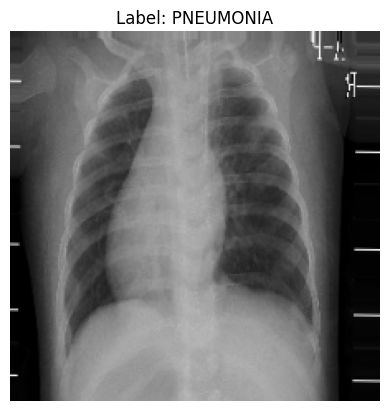

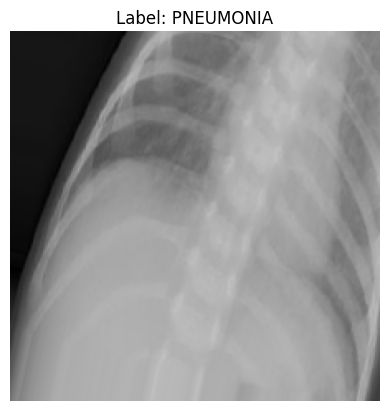

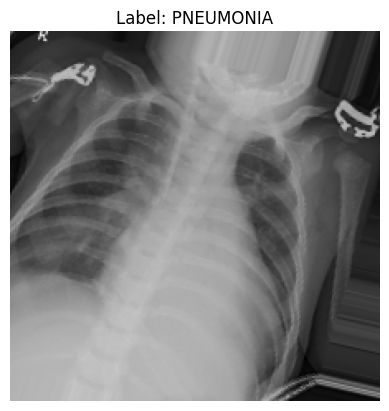

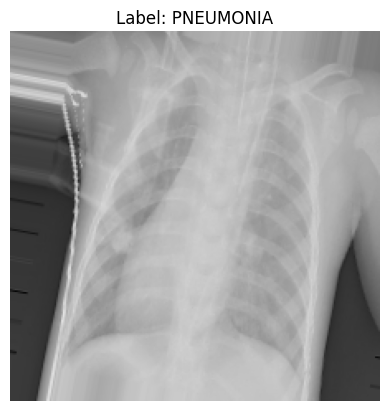

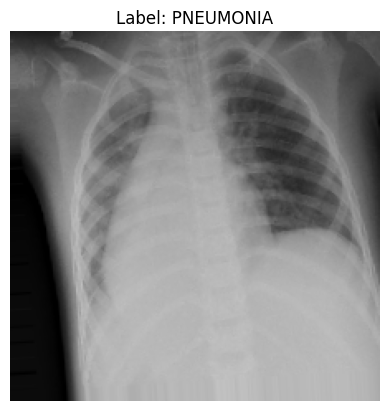

In [9]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)

for i in range(5):
    plt.imshow(x_batch[i])
    plt.title('Label: ' + ('PNEUMONIA' if y_batch[i] else 'NORMAL'))
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 781s 5s/step - accuracy: 0.7694 - loss: 0.4688 - val_accuracy: 0.6250 - val_loss: 0.6530
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 145s 727ms/step - accuracy: 0.8656 - loss: 0.2992 - val_accuracy: 0.6250 - val_loss: 1.2384
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 722ms/step - accuracy: 0.8703 - loss: 0.2895 - val_accuracy: 0.7500 - val_loss: 0.5571
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 123s 739ms/step - accuracy: 0.9045 - loss: 0.2287 - val_accuracy: 0.8125 - val_loss: 0.4416
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 122s 728ms/step - accuracy: 0.9279 - loss: 0.1995 - val_accuracy: 0.7500 - val_loss: 0.7538
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 120s 720ms/step - accuracy: 0.9220 - loss: 0.1988 - val_accuracy: 0.7500 - val_loss: 0.5409
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 122s 728ms/step - accuracy: 0.9240 - loss: 0.1969 - val_accuracy: 0.8125 - val_loss: 0.5273
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 121s 721ms/step - accuracy: 0.9259 - lo

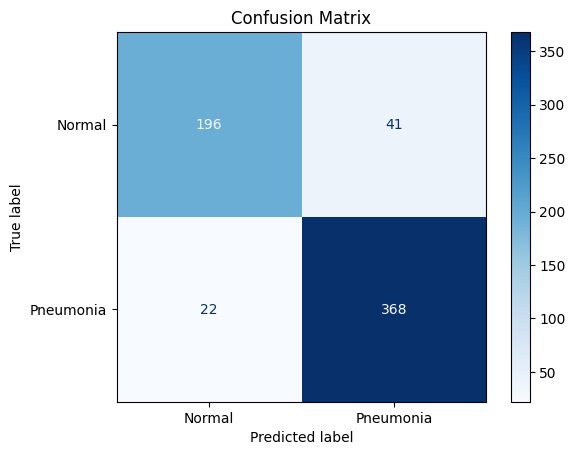

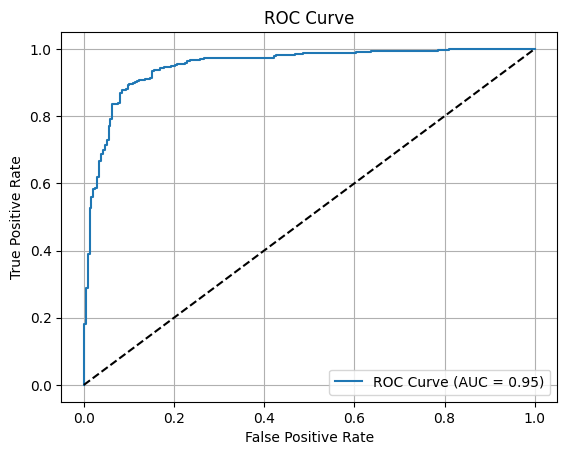

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)

#Accuracy, F1-Score, etc.
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class weights: {0: np.float64(1.9663212435233162), 1: np.float64(0.6704946996466431)}
Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 144s 802ms/step - accuracy: 0.7666 - loss: 0.8666 - val_accuracy: 0.5000 - val_loss: 17.1732 - learning_rate: 1.0000e-04
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 131s 785ms/step - accuracy: 0.8983 - loss: 0.2366 - val_accuracy: 0.5000 - val_loss: 21.6809 - learning_rate: 1.0000e-04
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 129s 771ms/step - accuracy: 0.9245 - loss: 0.1897 - val_accuracy: 0.5625 - val_loss: 5.0998 - learning_rate: 1.0000e-04
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 129s 771ms/step - accuracy: 0.9060 - loss: 0.2046 - val_accuracy: 0.6250 - val_loss: 0.9238 - learning_rate: 1.0000e-04
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 130s 775ms/step - accuracy: 0.9300 - loss: 0.1989 - val_accuracy: 0.6250 - val_loss: 3.0792 - learning_rate: 1.0000e-04
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9279 - loss: 0.1862
Epoch 6: ReduceLROnPlate

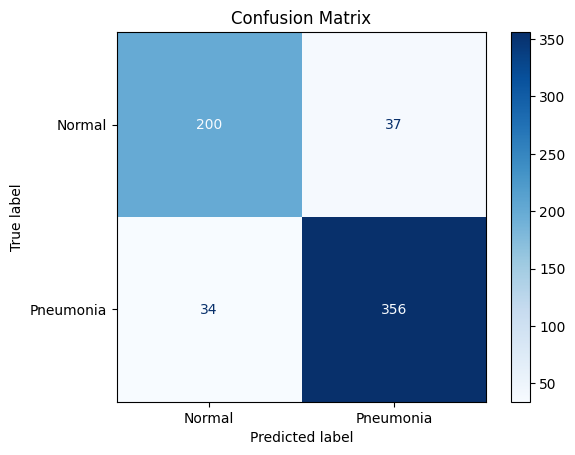

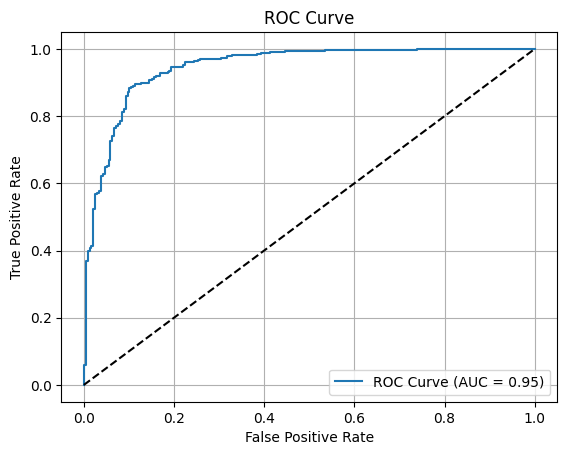

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # reduced from 0.5
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stop, lr_reduce]
)

#Accuracy, F1-Score, etc.
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 168s 863ms/step - accuracy: 0.7337 - loss: 0.5815 - val_accuracy: 0.5000 - val_loss: 0.8363 - learning_rate: 1.0000e-04
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 764ms/step - accuracy: 0.7515 - loss: 0.5680 - val_accuracy: 0.5000 - val_loss: 0.7960 - learning_rate: 1.0000e-04
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 767ms/step - accuracy: 0.7433 - loss: 0.5767 - val_accuracy: 0.5000 - val_loss: 0.7827 - learning_rate: 1.0000e-04
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 764ms/step - accuracy: 0.7416 - loss: 0.5761 - val_accuracy: 0.5000 - val_loss: 0.8199 - learning_rate: 1.0000e-04
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7471 - loss: 0.5726
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
167/167 ━━━━━━━━━━━━━━━━━━━━ 128s 769ms/step - accuracy: 0.7471 - loss: 0.5726 - val_accuracy: 0.5000 - val_loss: 0.8020 - learning_rate: 1.0000e

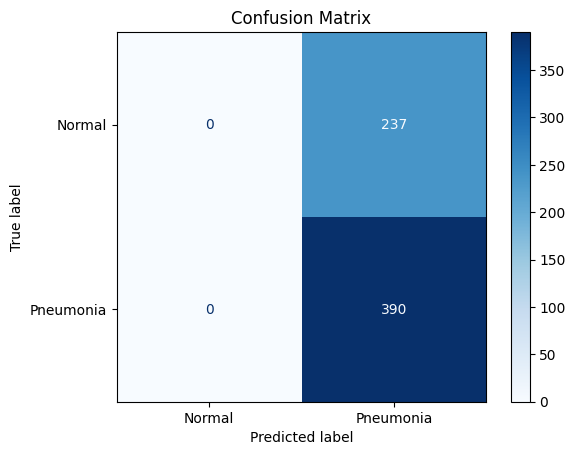

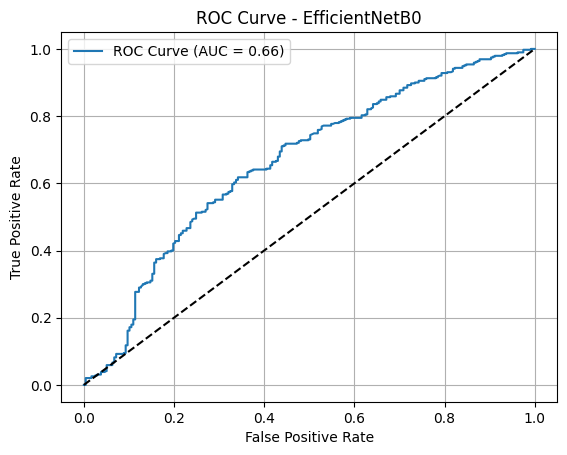

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, lr_reduce]
)

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Classification metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNetB0')
plt.legend()
plt.grid(True)
plt.show()

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp /content/project(1).ipynb /content/{LungVision}.ipynb'
Reinitialized existing Git repository in /content/.git/
fatal: pathspec '{LungVision}.ipynb' did not match any files
On branch main

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	drive/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)
error: remote origin already exists.
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/{lorenzojh}/{LungVision}.git'
